# 0 - Install Modules

In [71]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1 - Startup



In [124]:
import pandas as pd
import numpy as np

Read raw data

In [125]:
github_link = 'https://raw.githubusercontent.com/JuanRodrigues13/PUC-TCC/main/SKU_DATA.csv'

In [126]:
df_raw = pd.read_csv(github_link)

Setting Features

In [127]:
num_features = len(df_raw['DESCRIPTION'].str.split(',', -1, expand= True).columns)
features_list = []

for i in range(num_features):
  features_list.append('F{}'.format(i+1))

df_raw[features_list] = df_raw['DESCRIPTION'].str.split(',', -1, expand= True)

Setting SKU Family Dataframe

In [128]:
df_family = df_raw[[*features_list, *['SKU_FAMILY']]]

Setting Box Code Dataframe

In [129]:
df_box = df_raw[[*['SKU'], *features_list, *['BOX_CODE']]]
df_box = df_box[~df_box['BOX_CODE'].isnull()]

# 2 - Part Family Predict Model

In [133]:
df_family = df_family[df_family['SKU_FAMILY'].isin(['Miscellaneous', 'Motherboards', 'Mechanical', 'Keyboard/Mouse', 'SW', 'Cable', 'Base Unit', 'HDD', 'FPD', 'Card', 'PRC', 'Cover'])] #!= 'Tablet']

In [138]:
import category_encoders as ce

In [139]:
encoder = ce.OrdinalEncoder(cols=features_list)

df_family[features_list] = encoder.fit_transform(df_family[features_list])

In [140]:
encoder = ce.OrdinalEncoder(cols='SKU_FAMILY')

df_family['SKU_FAMILY_encoded'] = encoder.fit_transform(df_family['SKU_FAMILY'])

df_skus = df_family[['SKU_FAMILY', 'SKU_FAMILY_encoded']]

df_family['SKU_FAMILY'] = df_family['SKU_FAMILY_encoded']
df_family.pop('SKU_FAMILY_encoded')

0          1
1          1
2          1
3          1
4          1
          ..
228290     2
228292     2
228293    12
228294     5
228297     5
Name: SKU_FAMILY_encoded, Length: 183574, dtype: int64

In [141]:
X = df_family[features_list]
y = df_family['SKU_FAMILY']

Feature selecting using Chi²

In [142]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

fs = SelectKBest(chi2, k=5)
fit = fs.fit(X, y)

fit.get_support(indices= True)
features = fit.transform(X)
cols = fit.get_support(indices= True)
X = X.iloc[:,cols]

Dropped Features

In [143]:
dropped_features = df_family[features_list].columns.difference(X.columns).to_list()

In [144]:
df_family = df_family.drop(columns= dropped_features)

# 2.x - Data Split

In [145]:
from sklearn.model_selection import train_test_split

In [146]:
train_dataset, df_family =  train_test_split(df_family, test_size=0.1, stratify = df_family['SKU_FAMILY'])

In [147]:
df_family.shape

(18358, 6)

In [148]:
X = df_family.drop(columns='SKU_FAMILY')
y = df_family['SKU_FAMILY']

In [149]:
from imblearn.over_sampling import SMOTE

# Oversample
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)

df_family = over_X
df_family['SKU_FAMILY'] = over_y

In [150]:
df_family.shape

(50988, 6)

In [151]:
from sklearn.model_selection import train_test_split
np.random.seed(42)

# Split the data into 60% train and 40% test (later will divide the test to test and validate.)
train_dataset, temp_test_dataset =  train_test_split(df_family, test_size=0.2, stratify = df_family['SKU_FAMILY'])

# Split the test_dataset dataframe to 50% test and 50% validation. [this will divide the dataset into 60% train, 20% validate, and 20% test]
test_dataset, valid_dataset =  train_test_split(temp_test_dataset, test_size=0.5, stratify = temp_test_dataset['SKU_FAMILY'])

One hot labels

In [152]:
train_labels1 = train_dataset.pop('SKU_FAMILY')
test_labels1 = test_dataset.pop('SKU_FAMILY')
valid_labels1 = valid_dataset.pop('SKU_FAMILY')

In [153]:
# Encode the labels
train_labels = pd.get_dummies(train_labels1, prefix='Label')
valid_labels = pd.get_dummies(valid_labels1, prefix='Label')
test_labels = pd.get_dummies(test_labels1, prefix='Label')

train_labels

,Label_1,Label_2,Label_3,Label_4,Label_5,Label_6,Label_7,Label_8,Label_9,Label_10,Label_11,Label_12
43332,0,0,0,0,0,0,0,0,0,1,0,0
5951,0,0,0,0,0,0,0,0,1,0,0,0
42949,0,0,0,0,0,0,0,0,0,1,0,0
14105,0,0,0,0,0,1,0,0,0,0,0,0
10074,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
44129,0,0,0,0,0,0,0,0,0,1,0,0
15709,0,0,0,0,0,1,0,0,0,0,0,0
23870,0,0,0,1,0,0,0,0,0,0,0,0
20624,0,0,1,0,0,0,0,0,0,0,0,0


# Build a Neural Network Model 

# Training the model we built above.

In [154]:
# Tensorflow and Keras are two packages for creating neural network models.
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

# import NN layers and other componenets.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt # for plotting data and creating different charts.
import numpy as np # for math and arrays
import pandas as pd # data from for the data.
import seaborn as sns # for plotting.

In [166]:
%%time

# We decalred a function for creating a model.
def build_model1_two_hidden_layers():
    model = Sequential()
    model.add(Dense(512, input_dim = train_dataset.shape[1]))    # Input layer => input_shape must be explicitly designated   
    model.add(Dense(256, activation='tanh'))
    #model.add(Dropout(0.2))
    #model.add(Dense(64, activation='relu'))     
    model.add(Dense(len(train_labels1.drop_duplicates()), activation='softmax'))                          # Output layer => output dimension = 1 since it is a regression problem
     # Activation: sigmoid, softmax, tanh, relu, LeakyReLU. 
    #Optimizer: SGD, Adam, RMSProp, etc. # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
    learning_rate = 0.0001
    optimizer = optimizers.Adam(learning_rate)
    model.compile(loss='categorical_crossentropy',#from_logits=True),
                optimizer=optimizer,
                metrics=['accuracy']) # for regression problems, mean squared error (MSE) is often employed
    return model


EPOCHS = 50
batch_size = 16 # 6 iteration

model = build_model1_two_hidden_layers()
print('Here is a summary of this model: ')
model.summary()


with tf.device('/GPU:0'): # it can be with '/CPU:0'
# with tf.device('/GPU:0'): # comment the previous line and uncomment this line to train with a GPU, if available.
    history = model.fit(
        train_dataset, 
        train_labels,
        batch_size = batch_size,
        epochs=EPOCHS, 
        verbose=1,
        shuffle=True,
        steps_per_epoch = int(train_dataset.shape[0] / batch_size) ,
        validation_data = (valid_dataset, valid_labels),   
    )

Here is a summary of this model: 
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 512)               3072      
                                                                 
 dense_59 (Dense)            (None, 256)               131328    
                                                                 
 dense_60 (Dense)            (None, 12)                3084      
                                                                 
Total params: 137,484
Trainable params: 137,484
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
2549/2549 [==============================] - 7s 3ms/step - loss: 2.3785 - accuracy: 0.2013 - val_loss: 2.3244 - val_accuracy: 0.2126
Epoch 2/50
2549/2549 [==============================] - 6s 2ms/step - loss: 2.3093 - accuracy: 0.2148 - val_loss: 2.2879 - val_accura

# See how the training went.


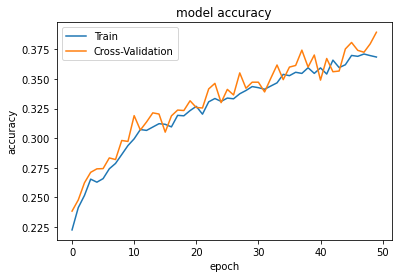

In [164]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper left')
plt.show()

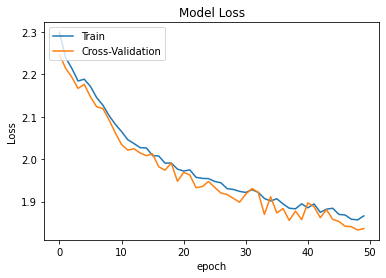

In [165]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper left')
plt.show()

In [ ]:
print('Train Split: ')
loss, accuracy = model.evaluate(train_dataset, train_labels, verbose=1)

print("Accuracy   : {:5.2f} ".format(accuracy))

In [ ]:
print('Evaluation Split: ')
loss, accuracy =  model.evaluate(valid_dataset, valid_labels, verbose=2)

print("Accuracy   : {:5.2f} ".format(accuracy))

In [ ]:
print('Test Split: ')
loss, accuracy =  model.evaluate(test_dataset, test_labels, verbose=2)

print("Accuracy   : {:5.2f}".format(accuracy))

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt     
from sklearn.metrics import confusion_matrix


ax= plt.subplot()
predict_results = model.predict(test_dataset)

# predict_results = (predict_results.argmax())
predict_results= predict_results.argmax(axis = 1)

cm = confusion_matrix(test_labels1, predict_results)

sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['Positive', 'Negative']); ax.yaxis.set_ticklabels(['Positive', 'Negative']);